# A WGAN-GP model for mimicking hand-drawn digits

This was built following a tutorial in the wonderful book Machine Learning with PyTorch and Scikit-Learn by Raschka, Liu and Mirjalili (2022, Packt Publishing). In this notebook, we do the following:

1. Build a Wasserstein Generative Adversarial Network with Gradient Penalty (WGAN-GP) which generates and critiques 28x28 1-channel (greyscale) images.
2. Train the model on the MNIST handwritten digit database (http://yann.lecun.com/exdb/mnist/) for 100 epochs (critic is trained for five iterations per epoch).
3. Plot generated samples at several epoch stages so we can qualitatively track our training progress.

Some commentary on our model choice, and some remarks about its features:

* A standard Generative Adversarial Network (GAN) typically uses:
    * Several fully-connected (FC) layers
    * Leaky ReLU activation functions to allow nonzero gradients for negative input values and in principle make the network more expressive overall.
    * BCE Loss function for the discriminator and the generator
* We instead use a Wasserstein GAN with GP (WGAN-GP) which differs from a standard GAN in several ways:
    * The FC layers are replace with transposed convolutional layers, which progressively upsample the 1x1 input feature space until we get 28x28 outputs.  A GAN with this convolutive structure is often called a Deep Convolutional GAN (DCGAN).
    * Implements a loss function based on the Wasserstein-1 distance (i.e. "earth-mover's distance" or EM distance) between real and fake image distributions.  This is intended to improve training performance, based on a theoretical argument that the generator should be trained to minimize the dissimilarity between these distributions.  See: http://proceedings.mlr.press/v70/arjovsky17a/arjovsky17a.pdf  Note that:
        * Computing the EM distance is intractible, but the loss functions we use essentially train the network to minimize an approximation of the EM distance (relying on the so-called Kantorovich-Rubinstein duality theorem).
        * The discriminator function in a standard GAN is essentially a classifier, outputting a probability.  Our new discriminator is often called a "critic", and outputs a scalar rating instead of a probability, and this rating can be interpreted as a measure of how realistic the input images are.
    * Uses a gradient penalty (GP) term on the discriminator loss function, in order to promote the 1-Lipschitz continuity property.  This property arises in the K-R duality theorem, which states that EM distance is equal to a particular supremum taken over all 1-Lipshitz continuous functions.  The original method for promoting 1-Lipshitz was weight clipping, but it was shown by Gulrajani et al (https://arxiv.org/pdf/1704.00028.pdf) that weight clipping can lead to exploding/vanishing gradients and capacity underuse and that GP can avoid these issues.
    * Batch Normalization is typically used in DCGAN models (and convolutional networks in general) to promote better and faster convergenc.  We use Layer Normalization (https://arxiv.org/abs/1607.06450) which is recommended as a drop-in replacement for Batch Normalization in WGAN-GP models.

Import necessary packages and set GPU device.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define generator and discriminator/critic model architectures.  The generator architecture is a standard instance of nn.Sequential.  The discriminator/critic architecture needs a custom child class of nn.Module consisting of a sequential network model and a slightly modified forward method.

In [2]:
def make_gen_net(input_size,num_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size,4*n_filters,4,1,0,bias=False),
        nn.InstanceNorm2d(4*n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(4*n_filters,2*n_filters,3,2,1,bias=False),
        nn.InstanceNorm2d(2*n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(2*n_filters,n_filters,4,2,1,bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters,1,4,2,1,bias=False),
        nn.Tanh()
    )
    return model

class Discriminator(nn.Module):
    def __init__(self,n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1,n_filters,4,2,1,bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters,2*n_filters,4,2,1,bias=False),
            nn.InstanceNorm2d(2*n_filters),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2*n_filters,4*n_filters,3,2,1,bias=False),
            nn.InstanceNorm2d(4*n_filters),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4*n_filters,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
    def forward(self,input):
        output=self.network(input)
        return output.view(-1,1).squeeze(0)

Import the MNIST dataset and create the DataLoader

In [3]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
image_path='./'

torch.manual_seed(1)
np.random.seed(1)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5),std = (0.5)),])
batch_size=64

mnist_dataset=torchvision.datasets.MNIST(root=image_path,train=True,transform=transform,download=False)
mnist_dl = DataLoader(mnist_dataset,batch_size=batch_size,shuffle=True,drop_last=True)

Define two functions:
1. create_noise creates a tensor of random values chosen using the specified distribution.  The tensor shape is (batch_size,z_size,1,1).
2. create_samples passes a latent tensor input_z through the current generator model to generate a batch of fake samples.

In [4]:
def create_noise(batch_size,z_size,mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size,z_size,1,1)*2-1
    elif mode_z == 'normal':
        input_z = torch,randn(batch_size,z_size,1,1)
    return input_z

def create_samples(g_model,input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output,(batch_size,*image_size))
    return (images+1)/2.0

Specify parameters and initialize generator and discriminator/critic networks.

In [5]:
z_size=100
n_filters=32

gen_model = make_gen_net(z_size,n_filters).to(device)
disc_model = Discriminator(n_filters).to(device)

g_opt = torch.optim.Adam(gen_model.parameters(),0.0002)
d_opt = torch.optim.Adam(disc_model.parameters(),0.0002)

In [6]:
print(gen_model)
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2

We will use a gradient penalty (GP) term in the loss function to promote the 1-Lipshitz property on the discriminator/critic.  We define the GP function, compute its gradient, and return the GP term for the loss function.

In [7]:
from torch.autograd import grad as torch_grad

def grad_penalty(real_data,gen_data):
    batch_size = real_data.size(0)
    
    # alpha is a random number sampled from (0,1) according to uniform distribution
    alpha = torch.rand(real_data.shape[0],1,1,1,requires_grad=True,device=device)
    
    # Interpolate between real and fake examples according to alpha value
    interpolated = alpha*real_data+(1-alpha)*gen_data
    
    # Compute the critic output for the interpolations
    proba_interpolated = disc_model(interpolated)
    
    # Calculate the gradients of the critic's outputs
    gradients = torch_grad(outputs=proba_interpolated,inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(),device=device),
                           create_graph=True,retain_graph=True)[0]
    gradients=gradients.view(batch_size,-1)
    gradients_norm = gradients.norm(2,dim=1)
    
    # Return the GP loss term
    return lambda_gp*((gradients_norm-1)**2).mean()

Training functions for the generator and discriminator/critic.

In [8]:
def d_train(x):
    disc_model.zero_grad()
    
    batch_size=x.size(0)
    x=x.to(device)
    
    # Compute the critic's rating for batch of real data
    d_real = disc_model(x)
    
    # Generate batch of fake data and compute critic's rating on that
    input_z = create_noise(batch_size,z_size,mode_z).to(device)
    g_output = gen_model(input_z)
    d_gen = disc_model(g_output)
    
    # Discriminator/critic loss, including GP term
    d_loss = d_gen.mean() - d_real.mean() + grad_penalty(x.data,g_output.data)
    
    # Backprop step
    d_loss.backward()
    d_opt.step()
    
    # Return the discriminator/critic loss
    return d_loss.data.item()
    
def g_train(x):
    gen_model.zero_grad()
    
    batch_size=x.size(0)
    
    # Generate batch of fake data and compute critic's rating on that
    input_z = create_noise(batch_size,z_size,mode_z).to(device)
    g_output=gen_model(input_z)
    d_gen = disc_model(g_output)
    
    # Generator loss
    g_loss = -d_gen.mean()
    
    # Backprop step
    g_loss.backward()
    g_opt.step()
    
    # Return generator loss
    return g_loss.data.item()

Train the models, keeping track of loss and also storing five samples after each epoch in epoch_samples.  Note that for every iteration of training the generator, the discriminator/critic is trained for critic_iterations iterations.

In [ ]:
mode_z='uniform'
lambda_gp=10.0
critic_iterations=5
fixed_z = create_noise(batch_size,z_size,mode_z).to(device)
epoch_samples=[]
num_epochs=100
torch.manual_seed(1)

for epoch in range(1,num_epochs+1):
    # At the end of each epoch we evaluate using gen_model, so set back to train at start of each epoch
    gen_model.train()
    
    d_losses, g_losses = [],[]
    for i, (x,_) in enumerate(mnist_dl):
        # Train the discriminator/critic for several iterations and record loss afterwards
        for _ in range(critic_iterations):
            d_loss=d_train(x)
        d_losses.append(d_loss)
        # Train generator for one iteration and record the loss afterwards
        g_losses.append(g_train(x))
    
    # Print discriminator/critic loss after each epoch
    print(f'Epoch {epoch:03d}| D Loss >> {torch.FloatTensor(d_losses).mean():.4f}')
    
    # Generate images based on fixed_z input after each epoch, so we can qualitatively track learning
    gen_model.eval()
    epoch_samples.append(create_samples(gen_model,fixed_z).detach().cpu().numpy())

Draw our the first five generated samples after epochs 1, 2, 4, 10, 50, 100

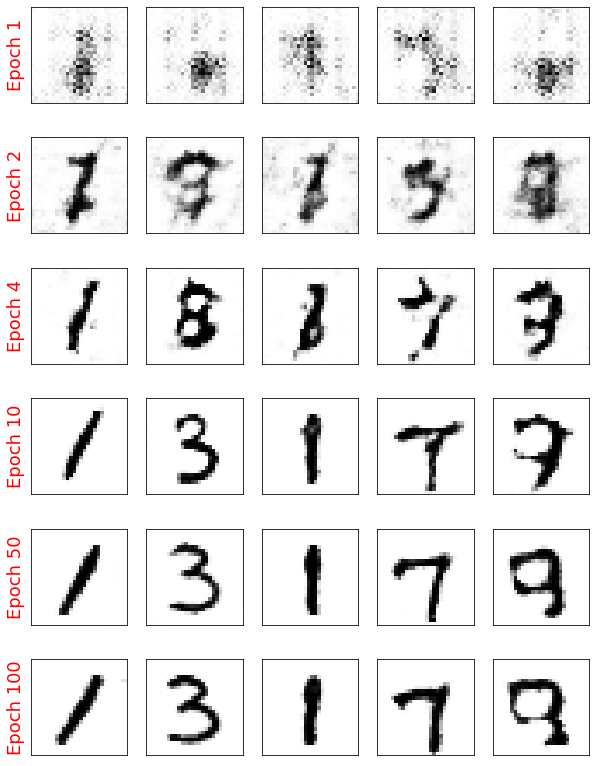

In [12]:
selected_epochs = [1,2,4,10,50,100]
fig = plt.figure(figsize=(10,14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6,5,i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.text(-0.06,0.5,f'Epoch {e}',rotation=90,size=18,color='red',horizontalalignment='right',verticalalignment='center',transform=ax.transAxes)
        image=epoch_samples[e-1][j]
        ax.imshow(image,cmap='gray_r')
            
plt.show()

Save our trained models for later use.

In [13]:
torch.save(gen_model,'mnist_WGAN-GP_gen_model.pth')
torch.save(disc_model,'mnist_WGAN-GP_disc_model.pth')
torch.save(gen_model.state_dict(),'mnist_WGAN-GP_gen_model_weights.pth')
torch.save(disc_model.state_dict(),'mnist_WGAN-GP_disc_model_weights.pth')